<b><font color="SteelBlue" size="+3">Classifiez automatiquement des biens de consommation</font></b>

# Introduction

Ce notebook est la suite de celui sur le traitement des descriptions. On récupère les données nettoyées pour les catégories des produits.

## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Traitement images
from matplotlib.image import imread
import time

# Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ML
#from sklearn import cluster, metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score


from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# perso
from Deveau_Estelle_4_IMG_func_042024 import *

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_txt_pretraitement_feature_extraction_faisaibilite_042024.ipynb',
 'Deveau_Estelle_2_NLP_func_042024.py',
 'Deveau_Estelle_3_notebook_img_pretraitement_feature_extraction_faisaibilite_042024.ipynb',
 'Deveau_Estelle_4_IMG_func_042024.py',
 'OC_projet6.pptx',
 'pythonProject',
 'svg',
 'Weather_Images_CNN_Transfer_Learning_Stage_1_feasibility_V1.0.ipynb',
 '__pycache__']

In [3]:
os.listdir("data/Cleaned/")

['data.csv']

In [4]:
path     = "./data/Cleaned/"
filename = "data.csv"

In [5]:
data = pd.read_csv(path + filename)

In [6]:
path     = "./data/Sources/Images/"
list_photos = [file for file in os.listdir(path)]
print(len(list_photos))

1050


# Exploration des données

## Quick tour

In [7]:
data.head()

,uniq_id,product_category,description
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,Key Features of Elegance Polyester Multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...


In [8]:
data.shape

(1050, 3)

In [9]:
data.dtypes.value_counts()

object    3
Name: count, dtype: int64

In [10]:
data.nunique()

uniq_id             1050
product_category       7
description         1050
dtype: int64

In [11]:
# Valeurs manquantes
missing_values_count = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 0.0 %


In [12]:
# Liste de toutes les colonnes à conserver
cols_to_keep = ['uniq_id', 'product_category']

In [13]:
df = data[cols_to_keep]

In [14]:
df.head(5)

,uniq_id,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing


In [15]:
print("Valeurs uniques pour product_category dans df:", df['product_category'].unique())

Valeurs uniques pour product_category dans df: ['Home Furnishing' 'Baby Care' 'Watches' 'Home Decor & Festive Needs'
 'Kitchen & Dining' 'Beauty and Personal Care' 'Computers']


## Exemples d'images

In [16]:
def get_images_for_category(category, num_images=3):
    """Récupère les noms de fichiers des images pour une catégorie donnée."""
    category_ids = df[df['product_category'] == category]['uniq_id']
    category_images = [f"{id}.jpg" for id in category_ids if f"{id}.jpg" in list_photos]
    return category_images[:num_images]

Catégorie : Home Furnishing


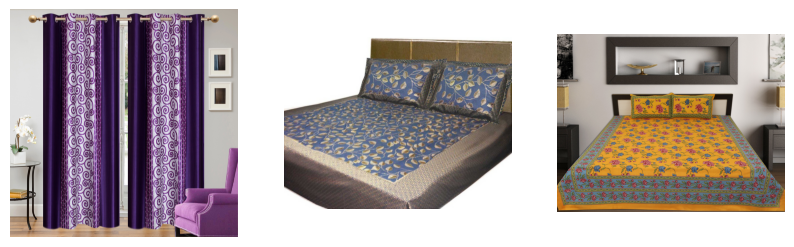

Catégorie : Baby Care


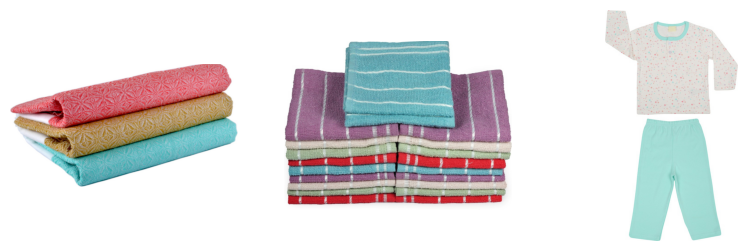

Catégorie : Watches


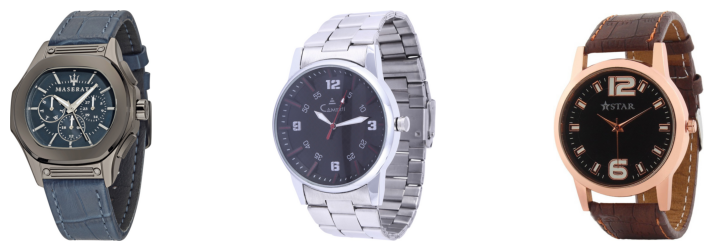

Catégorie : Home Decor & Festive Needs


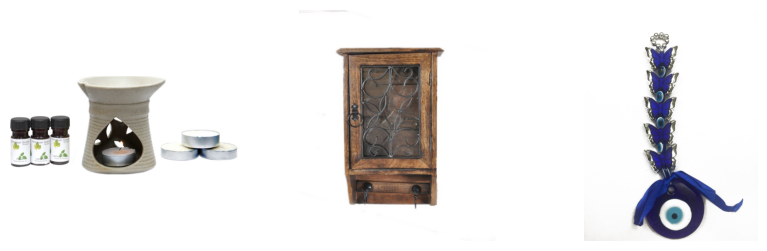

Catégorie : Kitchen & Dining


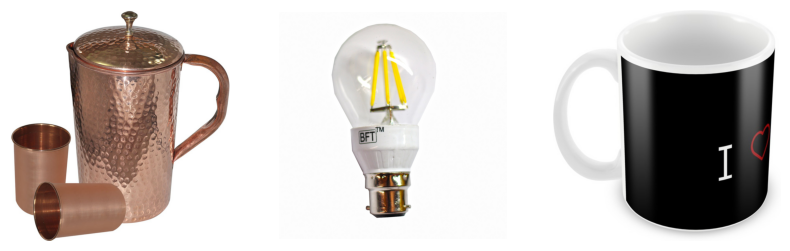

Catégorie : Beauty and Personal Care


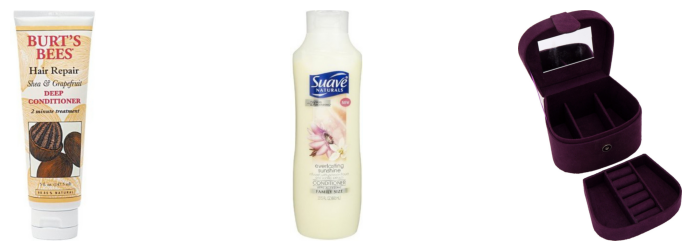

Catégorie : Computers


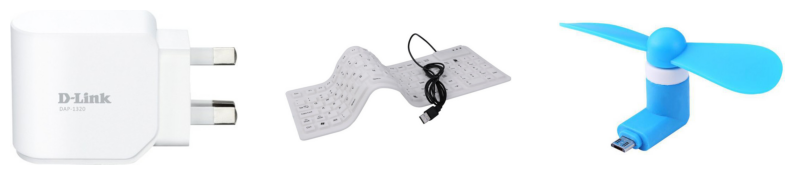

In [17]:
# Affichage des images
for category in df['product_category'].unique():
    print(f"Catégorie : {category}")
    category_images = get_images_for_category(category, 3)
    plt.figure(figsize=(10, 3)) 
    for i, image_name in enumerate(category_images):
        plt.subplot(1, 3, i+1)  
        filename = os.path.join(path, image_name)
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off') 
    plt.show()

# Pré-traitements des Images avec SIFT

## Détermination des descripteurs

### Sur une image

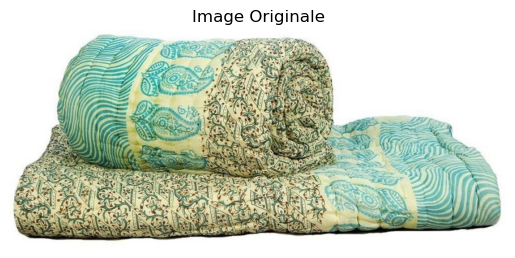

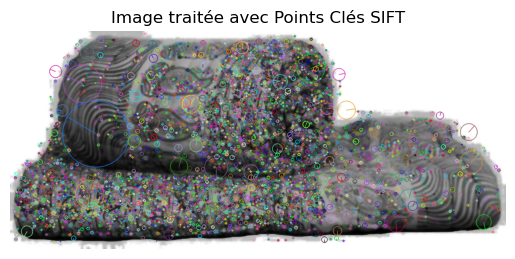

Descripteurs :  (3946, 128)
[[ 40.   2.   2. ...   0.   0.   1.]
 [134.  16.   0. ...   0.   4.   3.]
 [ 44.  91.   8. ...   0.   0.   4.]
 ...
 [  7.   5.  37. ...   0.   1.   6.]
 [ 17.   0.   0. ...   0.   0.   2.]
 [132.  81.   0. ...   0.   0.   1.]]


In [18]:
# Chemin de l'image
image_path = path + list_photos[1000]
original_image = cv2.imread(image_path)
plt_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.title("Image Originale")
plt.imshow(plt_image)
plt.axis('off')
plt.show()

# Traitement de l'image avec la fonction process_image
keypoints, descriptors, processed_image = process_image(image_path)

# Affichage des points clés sur l'image
if descriptors is not None:
    display_keypoints(processed_image, keypoints, "Image traitée avec Points Clés SIFT")
    print("Descripteurs : ", descriptors.shape)
    print(descriptors)
else:
    print("Aucun descripteur trouvé.")

### Sur chaque image

In [19]:
# Initialisation du temps
temps1 = time.time()

image_paths = [f"{path}{uid}.jpg" for uid in df['uniq_id']]

sift_keypoints_by_img, sift_keypoints_all = process_images_concurrently(image_paths)

duration1 = time.time() - temps1

print("Dimensions des descripteurs par image :", sift_keypoints_by_img.shape)
print("Nombre total de descripteurs :", sift_keypoints_all.shape)
print("Temps de traitement des descripteurs SIFT : ", "{:.2f}".format(duration1), "secondes")

Dimensions des descripteurs par image : (1050,)
Nombre total de descripteurs : (2961542, 128)
Temps de traitement des descripteurs SIFT :  114.08 secondes


## Création des clusters de descripteurs

In [20]:
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42, n_init=10)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("Temps de traitement kmeans : ", "{:.2f}".format(duration1), "secondes")

Nombre de clusters estimés :  1721
Création de 1721 clusters de descripteurs ...
Temps de traitement kmeans :  90.60 secondes


## Création des features des images

In [21]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("Temps de traitement kmeans : ", "{:.2f}".format(duration1), "secondes")

0
100
200
300
400
500
600
700
800
900
1000
Temps de traitement kmeans :  39.34 secondes


## Réduction de dimension

### ACP

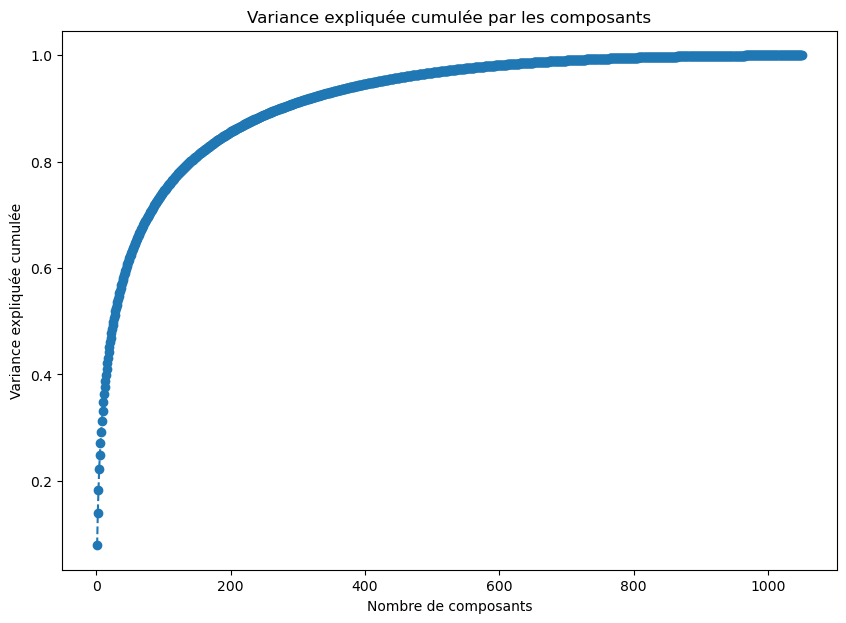

In [22]:
# Création de l'ACP
pca = PCA()

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(im_features)

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [23]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_99 = np.where(cumulative_variance >= 0.99)[0][0] + 1

print(f"Nombre de composantes pour atteindre 99% de variance expliquée : {n_components_99}")

Nombre de composantes pour atteindre 99% de variance expliquée : 699


In [24]:
# PCA
pca = PCA(n_components=n_components_99, svd_solver='randomized', random_state=42)
reduced_im_features = pca.fit_transform(im_features)

### T-SNE

In [25]:
# Encodage des catégories
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(df['product_category'])
category_names = label_encoder.classes_

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.011853
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.064194
[t-SNE] KL divergence after 1000 iterations: 1.867219
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.013703
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.733231
[t-SNE] KL divergence after 1000 iterations: 1.625171
[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in

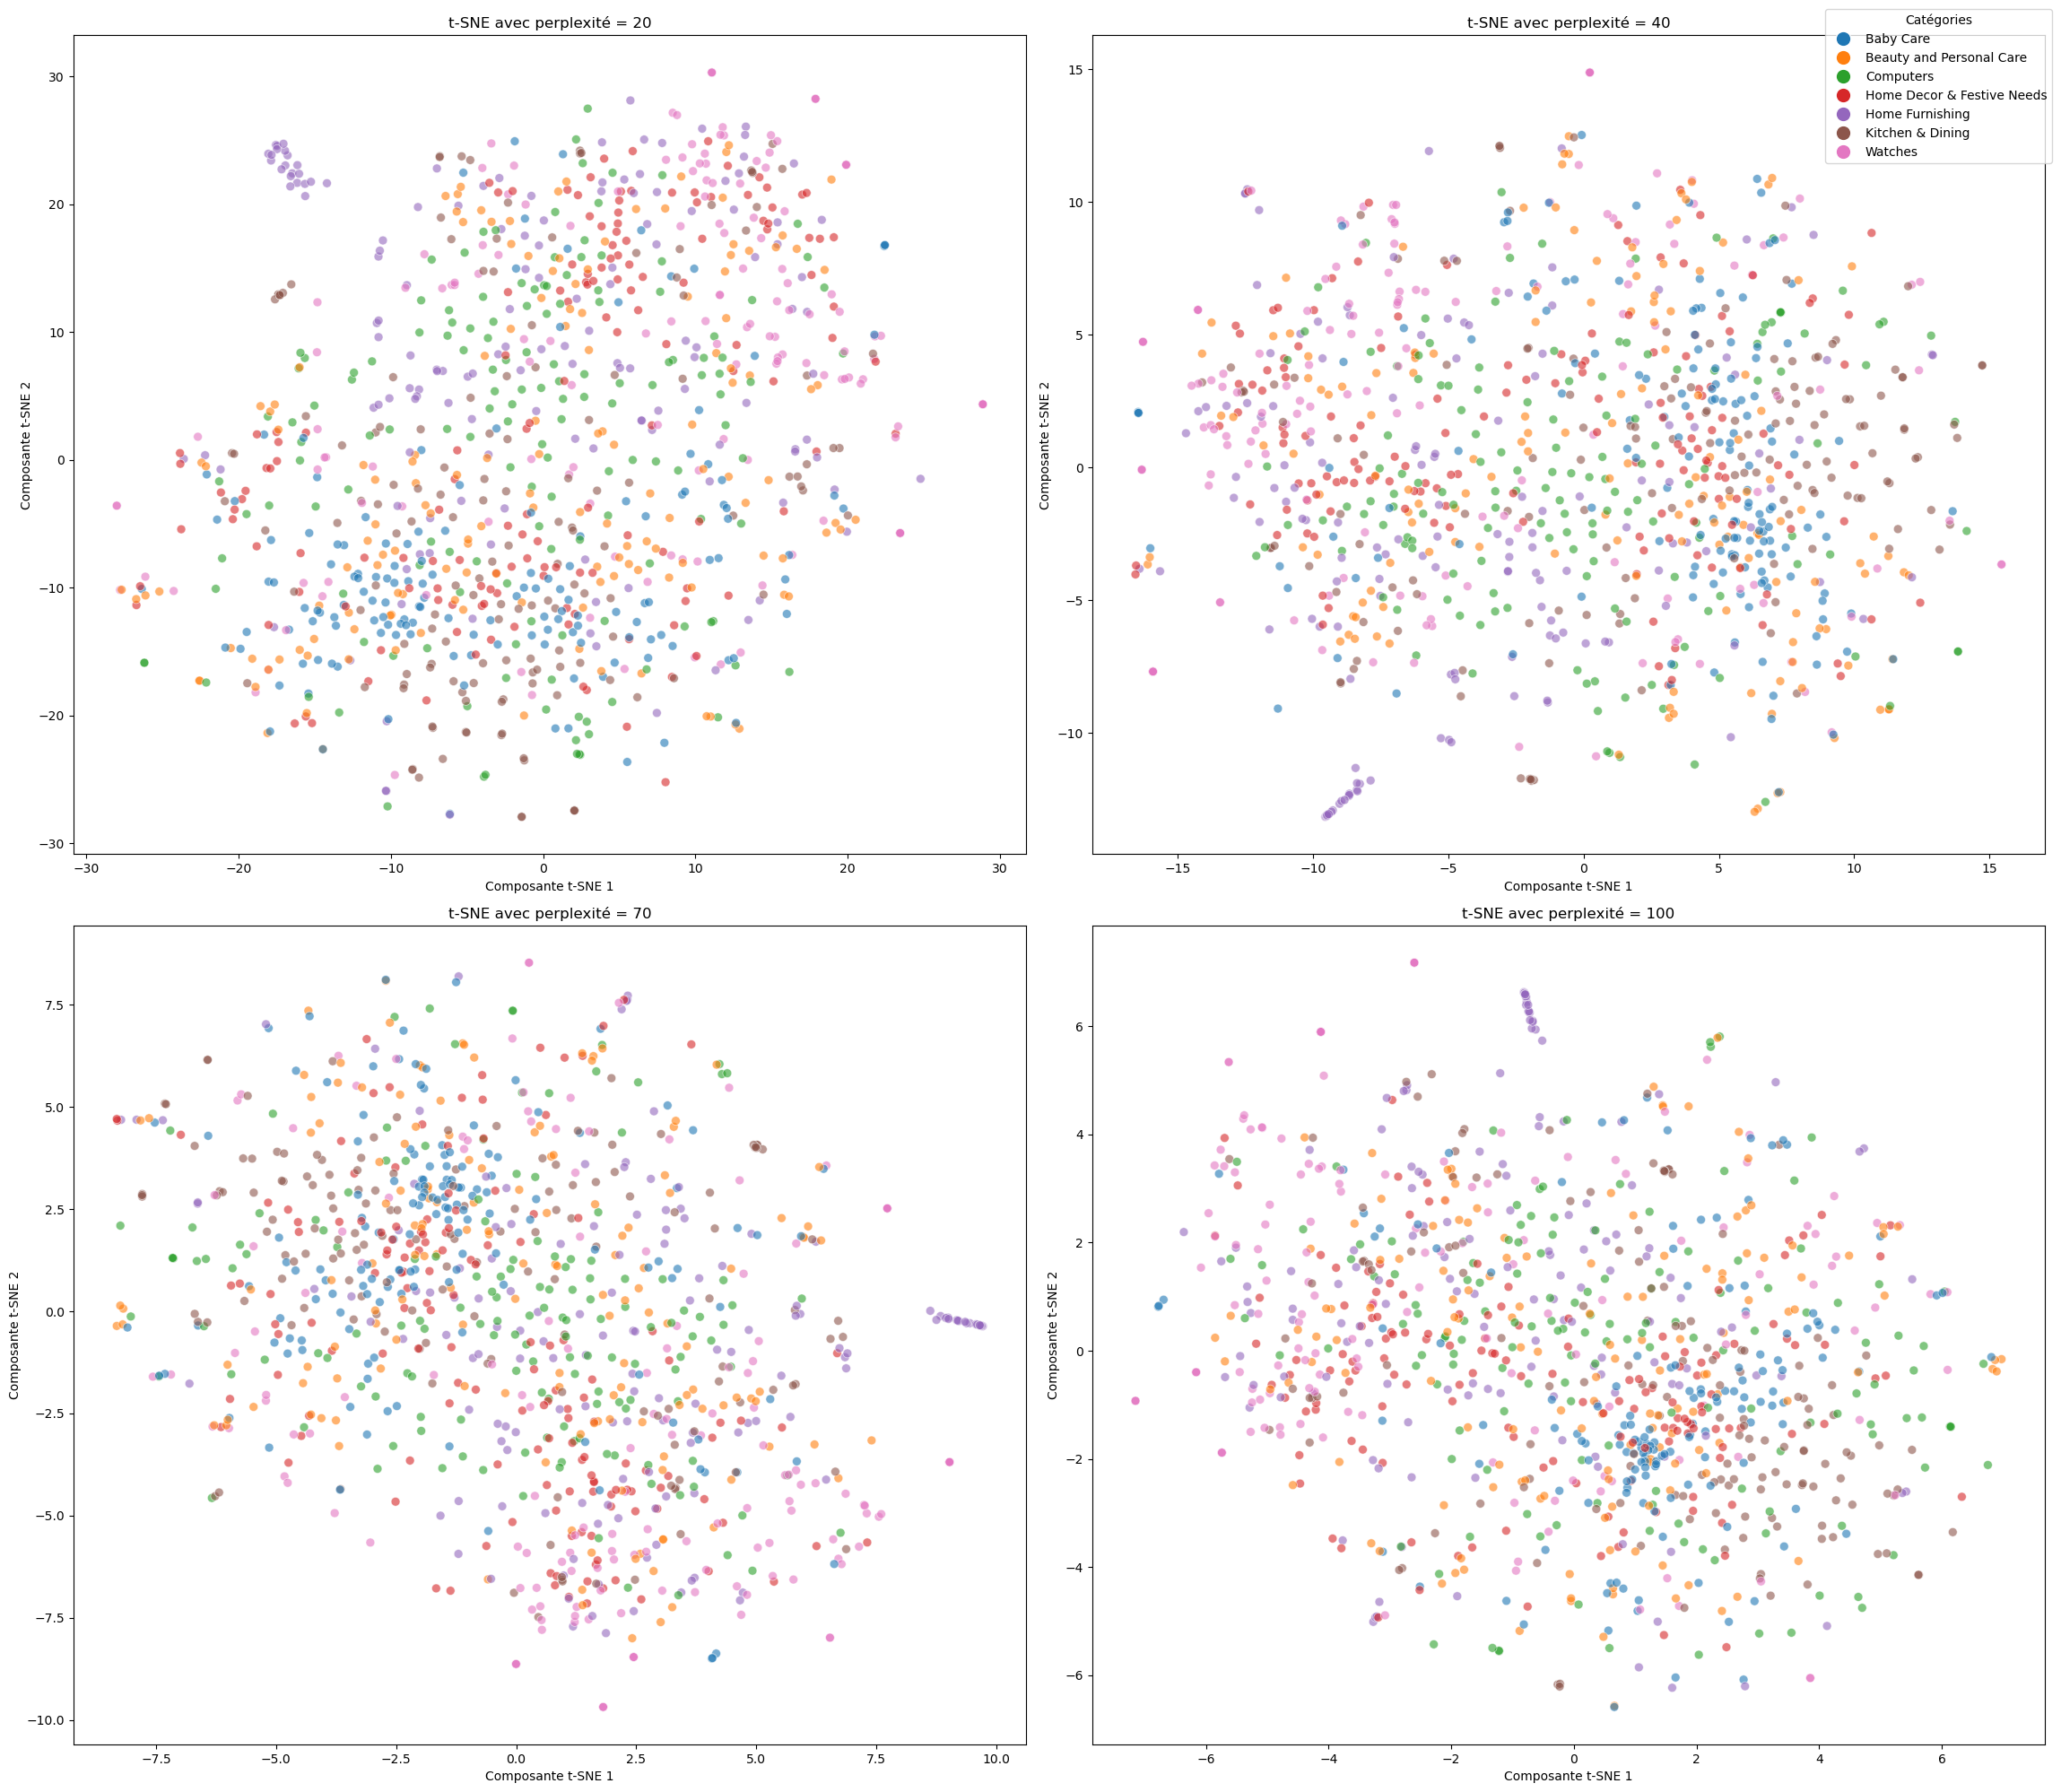

In [26]:
plot_tsne_grid(reduced_im_features, categories_encoded, category_names)

In [27]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, random_state=42)
tsne_reduced_im_features = tsne.fit_transform(reduced_im_features)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.011853
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.064194
[t-SNE] KL divergence after 1000 iterations: 1.867219


# Pré-traitement des images avec CNN

# K-means

In [28]:
# Nombre de clusters
n_clusters = 7

## Sur SIFT

Silhouette Score: 0.2422
Adjusted Rand Score: 0.0517
Accuracy: 0.2762


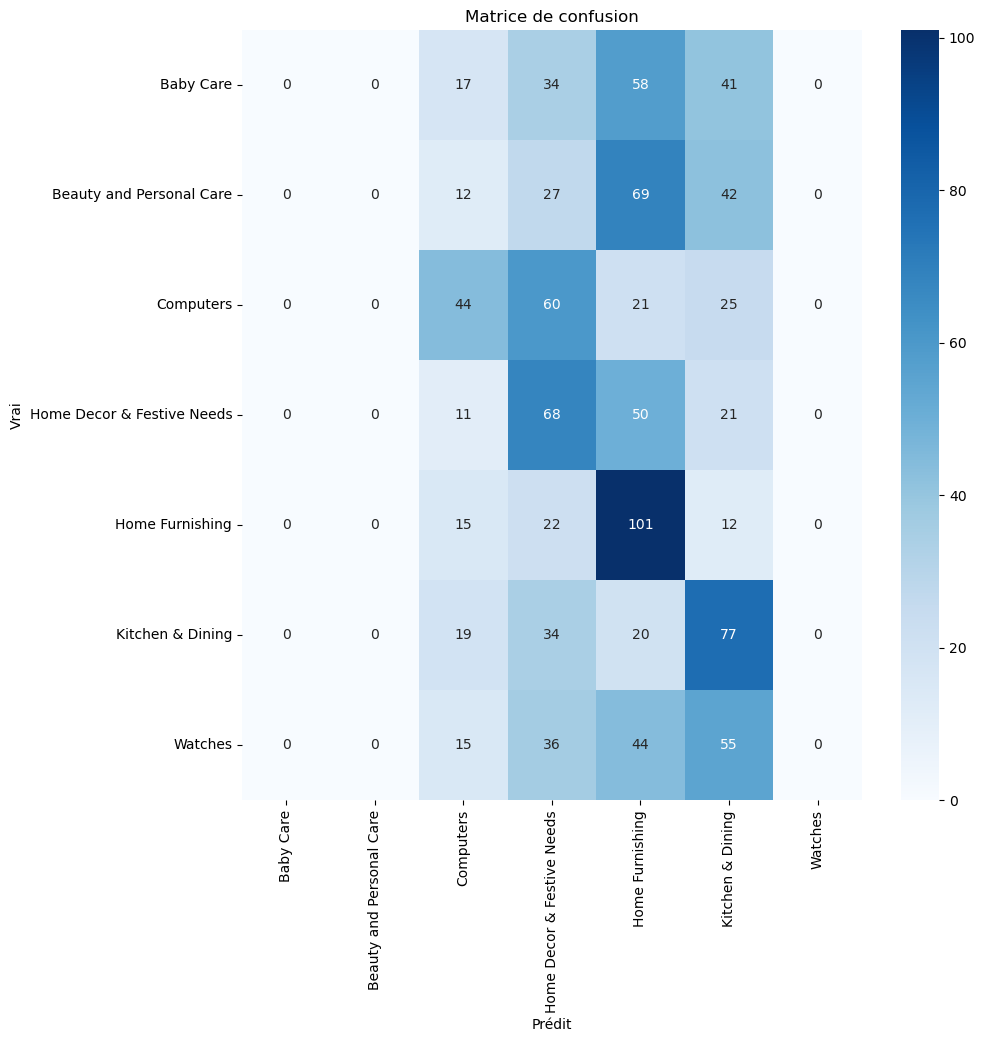

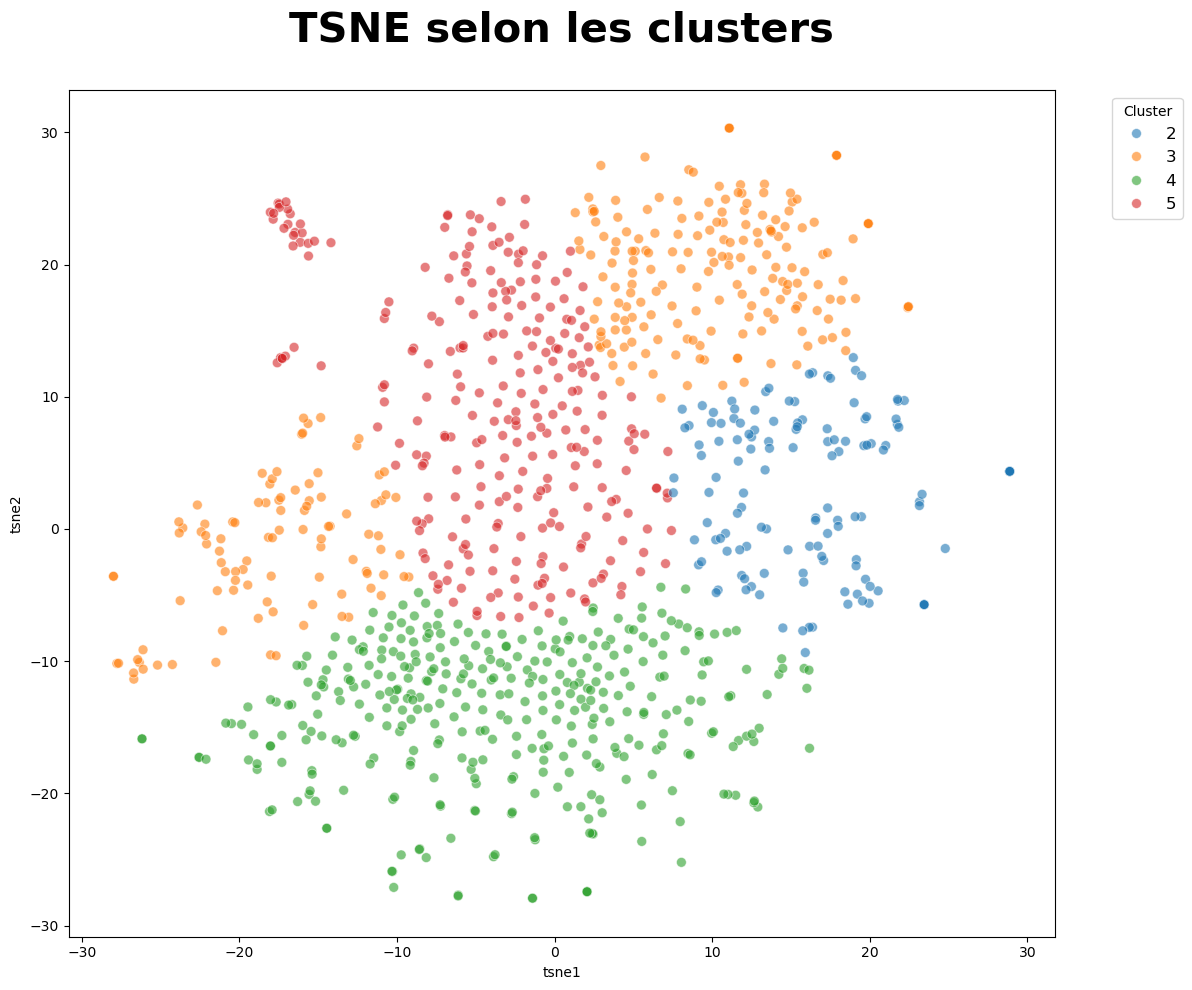

In [29]:
kmeans_metrics = perform_kmeans(X_data=tsne_reduced_im_features, true_labels=categories_encoded, label_names=category_names,
                                n_clusters=n_clusters, random_state=42)

## Sur CNN

## Sur Deep Learning + augmented data

## Comparaison des résultats

# Modèles de machine learning supervisé

## Sur T-SNE TF-IDF

### Naive Bayes

### SVM

### Random Forest

## Comparaison des résultats